In [1]:
import numpy as np
import pandas as pd
import math
import  matplotlib.pyplot as plt

**Data Import**

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/atreish/AIM_5007_Neural_Networks_-_Deep_Learning/main/seeds_dataset.txt',
                   sep='\s+',header=None, names = ['Area','Perimeter','Compactness','Klength','Kwidth','Asym_coeff','length of kernel groove','class_label'])
data.head(5)

,Area,Perimeter,Compactness,Klength,Kwidth,Asym_coeff,length of kernel groove,class_label
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


**Data Cleaning**

In [3]:
#Normalize Numeric Data, Not the label column
data.iloc[:,:-1] = data.iloc[:,:-1].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

#Shuffle the dataset to ensure the network is trained on all 3 available classes
data1 = data.sample(frac=1).reset_index(drop=True)

#Change X  (numeric columns) and y (class columns) to arrays and the target datatype to int
X = np.array(data1)[:, :-1]
y = np.array(data1)[:, -1].astype(int)

#Apply one hot encoding for each class, this will be our target class 
target_layer = []
for i in y:
    if i == 1:
        target_layer.append([1,0,0])
    elif i == 2:
        target_layer.append([0,1,0])
    else:
        i == 3
        target_layer.append([0,0,1])
        
target_layer = np.array(target_layer)

#Train-test split 150/60
X_train = X[:150]
X_test = X[150:]
y_train = target_layer[:150]
y_test = target_layer[150:]

**Neural Network Functions for [7,7,3] Architecture**

In [4]:
'''Activation Function for this network'''

def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

'''Append the entire matrix with a column of ones for the bias node'''

def append(X):
    height = X.shape[0] 
    bias_column = np.ones((height,1))
    X_appended = np.hstack((X,bias_column))
    return X_appended

'''Initializes a Weight Matrix from the input layer to the hidden layer using the length of a single row 
for argument Matrix X'''

def w_input(X):
    X_appended = append(X)
    rows = len(X[0]) 
    cols = len(X[0])
    W = np.random.sample((cols, rows)) - 0.5
    random_bias_weight = np.random.sample()
    bias_row = np.repeat(random_bias_weight, rows)
    W_input = np.insert(W, cols, bias_row, axis=0)
    return W_input

'''This is the dot product between a weight matrix and the appended X matrix (one row at a time), this returns
an unactivated hidden layer of length 7, as specified by the dimensions of the problem'''

def h_raw(X,i,weight1=None): 
    if weight1 is None:
        weight1 = w_input(X)
    X_appended_row = append(X)[i]
    hraw = np.dot(X_appended_row, weight1)
    return hraw, weight1

'''This function now activates the hidden layer by applying the sigmoid activation function and returns the 
weight that was used to get from the input layer to the hidden layer'''

def h_activated(X,i,weight1=None):
    hidden_layer_raw, weight1 = h_raw(X,i,weight1)
    hactivated = sigmoid(hidden_layer_raw)
    return hactivated, weight1

'''Initializes a Weight Matrix for the hidden to output layer using the length of the activated hidden layer,
this also appends a random weight at the bottom of the matrix for the bias from hidden to output layer'''

def w_output(X, i, y_train, weight1=None):
    hactivated, _ = h_activated(X,i,weight1=weight1)
    rows = len(hactivated)
    W = np.random.sample((rows, 3)) - 0.5
    random_weight = np.random.sample([1]) - 0.5
    weight_vector = np.repeat(random_weight,3)
    W_output = np.insert(W, rows, weight_vector, axis=0)
    return W_output

'''This is the dot product between an appended activated hidden layer and W_output, this gives us the first
output layer values'''

def o_raw(X,i, weight1=None, weight2=None):
    hactivated, weight1 = h_activated(X, i , weight1)
    h_activated_with_bias = np.append(hactivated,[1]) 
    if weight2 is None:
        weight2 = w_output(X,i,weight1)
    oraw = np.dot(h_activated_with_bias, weight2)
    return oraw, weight2

'''This function now activates the output layer by applying the sigmoid activation function and returns the 
weight that was used to get from the hidden layer to the output layer'''

def o_activated(X,i, weight1=None, weight2=None):
    oraw, weight2 = o_raw(X,i, weight1=weight1, weight2=weight2)
    oactivated = sigmoid(oraw)
    return oactivated, weight2

'''This Error function determines the error of the output for the i-th row of the Matrix and the i-th target layer
and outputs a single value that will be used in the backpropogation steps'''

def error(X,y,i,weight1=None, weight2=None):
    oactivated, _ = o_activated(X, i, weight1=weight1, weight2=weight2)
    error = .5*((y[i] - oactivated)**2).sum()
    return error

'''The Feedforward Steps all conglomerated into one function from X matrix row to output activated. This catch-all
function will return the outputlayer actived for the i-th row, the weight matricies used form both the input layer
to hidden layer and from the hidden layer to the input layer and the associated erro'''

def feedforward(X, y, i, weight1=None, weight2=None):
    hactivated, weight1 = h_activated(X,i, weight1)
    oactivated, weight2 = o_activated(X,i, weight1=weight1, weight2=weight2)
    err = error(X,y,i,weight1=weight1, weight2=weight2)
    return oactivated, hactivated, err, weight1, weight2

'''First Step in Backpropogation, this produces the Gradient Matrix from the Hidden Layer to the
Output Layer (8x3)'''

def grad_hidden_to_output(X,y,i, oactivated, hactivated): 
    E = (oactivated - y[i]) * oactivated * (1 - oactivated)
    h_activated_transpose = np.array([[i] for i in hactivated])
    grad_hidden_to_output = h_activated_transpose * E 
    bias_gradient = ((oactivated - y[i]) * oactivated * (1 - oactivated)).sum()
    bias_h2o =  np.array([bias_gradient])
    len_bias_row = grad_hidden_to_output.shape[1]
    BG_H_O = np.repeat(bias_h2o[0],len_bias_row)
    hidden_to_output_gradient_matrix = np.vstack([grad_hidden_to_output, BG_H_O])
    return hidden_to_output_gradient_matrix

'''The Gradient Matrix from the Input Layer to the Hidden Layer (8x7)'''

def grad_input_to_hidden(X, y, i, oactivated, hactivated, W_output):
    input_layer = X[i]
    target_layer = y[i]
    W_output_wo_bias = W_output[:-1,:] 
    E = (oactivated - target_layer) * oactivated * (1 - oactivated) 
    grad_input_to_hidden = np.zeros((7,7))
    for j in range(len(hactivated)):
        pt1 = []  
        pt2 = []
        pt1.append( np.dot(E, W_output_wo_bias[j]) ) 
        pt2.append( hactivated[j] * (1 - hactivated[j])) 
        grad_input_to_hidden[:,j] = np.array(pt1) * np.array(pt2) * input_layer
    pt3 = np.dot(E, W_output_wo_bias.T)
    pt4 = hactivated *(1-hactivated)
    bias_gradient_il = np.dot(pt3,pt4)
    len_bias_row = hactivated.shape[0]
    BG_I_H = np.repeat(bias_gradient_il, len_bias_row)
    input_to_hidden_gradient_matrix = np.vstack((grad_input_to_hidden, BG_I_H))
    return input_to_hidden_gradient_matrix

'''Updated Weights from the Input to Hidden Layer with learning rate lr'''

def update_input_hidden_weights(X,y,i,lr, oactivated, hactivated, weight1=None, weight2=None):
    input_to_hidden_gradient_matrix = grad_input_to_hidden(X, y, i, oactivated, hactivated, weight2)
    updated_weights_input_hidden = weight1 - lr * input_to_hidden_gradient_matrix
    return updated_weights_input_hidden

'''Updated Weights for Hidden to Output Layer with lr'''

def update_hidden_output_weights(X,y,i,lr, oactivated, hactivated, weight2=None):
    hidden_to_output_gradient_matrix =  grad_hidden_to_output(X,y,i, oactivated, hactivated)
    updated_weights_hidden_output = weight2 - lr * hidden_to_output_gradient_matrix
    return updated_weights_hidden_output

'''Backpropogation Function'''

def backpropogation(X,y,i,lr,oactivated,hactivated,weight1=None, weight2=None):
    updated_weight1 = update_input_hidden_weights(X,y,i,lr, oactivated, hactivated, weight1=weight1, weight2=weight2)
    updated_weight2 = update_hidden_output_weights(X,y,i,lr, oactivated, hactivated, weight2)
    oactivated1, hactivated1, err, updated_weight1, updated_weight2 = feedforward(X, y, i, weight1=updated_weight1, weight2=updated_weight2)
    return err, oactivated1, updated_weight1, updated_weight2

'''Transforms the Rows of all oactivated1 to one hot encoding to compare with y_trian'''

def output_encoder(Matrix):
    for row in Matrix:
        row[row.argmax(0)] = 1
        row[row < 1] = 0
    return Matrix

'''Creates a visualization of the Errors'''

def error_plotter(Matrix,threshold): 
    result = np.array(list(map(sum, Matrix))) / len(Matrix[0])
    index = np.array(list(range(len(result))))
    Ezz = np.vstack((index+1, result)).T
    x = Ezz[:,0]
    y = Ezz[:,1]
    plt.figure(figsize=(7,5))
    plt.plot(x,y)
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.show

'''This function returns the number of EPOCHS needed to reach convergence to the error threshold'''
    
def epochs_for_convergence(avg_error, threshold, X):
    for i in range(len(avg_error)):
        if avg_error[i] < threshold:
            count = i / len(X)
            return math.ceil(count)
        
def epochs_for_mean_convergence(normalized_error, threshold):
    for i in range(len(normalized_error)):
        if normalized_error[i] < threshold:
            count = i
            return math.ceil(count)

# EXPERIMENT 1: Different Learning Rates

``Using the given Neural Network functions and using the Sigmoid Activation function we will use the Seeds Dataset to experiment with different learning rates. The following NN_traing() function uses Stochastic Gradient
Descent and updates the weights one observation at a time for all given epochs. That means the the weights will
be updated (150 x n_epochs) and output as a result. This function will also provide us with Mean error for the 
Final epoch, the earlist epoch that witnesses the error of a single observation dip below our given threshold,
and the epoch in which the mean error dips below the given threshold.``

In [5]:
def nn_training(X, y, lr, threshold=.001, epoch_count=1000):
    wt1 = None
    wt2 = None
    final_output = []
    errors = [] 
    avg_error = [] 
    for n in range(epoch_count):   
        M = np.concatenate((X, y), axis=1)
        M = pd.DataFrame(M)
        M1 = M.sample(frac=1).reset_index(drop=True)
        XX_train = np.array(M1.iloc[:,:7])
        yy_train = np.array(M1.iloc[:,7:])
              
        for i in range(XX_train.shape[0]):  
            oact, hact, err, wt1, wt2 = feedforward(XX_train,yy_train,i,weight1=wt1, weight2=wt2)
            err, oactivated1, updated_weight1, updated_weight2 = backpropogation(XX_train,yy_train,i,lr,oactivated=oact,hactivated=hact,weight1=wt1, weight2=wt2)
            wt1 = updated_weight1
            wt2 = updated_weight2
            final_output.append(oactivated1)
            errors.append(err)
            avg_error.append(err)
    
    epoch_errors = np.reshape(errors,(epoch_count, len(X)))
    normalized_errors = np.array(list(map(sum,  epoch_errors))) / len( epoch_errors[0])
    
    epochs_single_convergence = epochs_for_convergence(avg_error, threshold, X)
    epochs_mean_convergence = epochs_for_mean_convergence(normalized_errors, threshold)
    
    output = np.asarray(final_output[-len(X):])
    encoded_output = output_encoder(output)      
    tot = np.sum(np.all(encoded_output == yy_train, axis=1))
    accuracy = tot/len(y) 
    
    print('-------------------------------------------------------------------------------------------------')
    print('After {} epochs, and a learning rate of {} the model accuracy is {}%'.format(epoch_count,lr,round(accuracy*100, 2)))
    print('Mean Error of the Final Epoch = {}'.format(round(normalized_errors[-1],5)))
    print('The Number of Epochs for a single activated output layer error to dip below the threshold is {}'.format(epochs_single_convergence))
    print('The Number of Epochs for the Mean Epoch Error to dip below the threshold is {}'.format(epochs_mean_convergence))
    
    return wt1, wt2

``This testing function will now provide the accuracy of a single feedforward pass for all observations using the
obtained weights for each learning rate``

In [6]:
def nn_testing(X, y,wt1,wt2,lr):
    final_output = []
    errors = [] 
    for i in range(X.shape[0]):  
        oact, hact, err, wt1, wt2 = feedforward(X,y,i,weight1=wt1, weight2=wt2)
        final_output.append(oact)
        errors.append(err)
    output = np.asarray(final_output[-len(X):])
    encoded_output = output_encoder(output)      
    tot = np.sum(np.all(encoded_output == y_test, axis=1))
    accuracy = tot/len(y_test)
    print('\nAccuracy using updated weights from training set with lr={} is {}%'.format(lr,round(accuracy*100, 2)))
    return

```The following is our actual experiment where we assign one out of a list of learning rates and capture their output updated weight matricies. We also observe their final Epoch Mean Error, accuracy, the number of epochs for both a single observation's error and the mean epoch error to dip below the threshold. In our previous experiments, we obtained over 92% accuracy on testing data after 3000 epochs, and the mean epoch error dips below
the threshold before epoch 1000. Here we will use 2500 epochs. Finally, the captured weights are tested on our validation set to determine the accuracy obtained for each learning rate.```

In [7]:
learning_rates = [.001,.05,.1,.2,.6,.9, .999]
W1 = []
W2 = []
for i in learning_rates:
    wt1, wt2 = nn_training(X_train, y_train, i, threshold=.01, epoch_count=2500)
    W1.append(wt1)
    W2.append(wt2)

for i in range(len(W1)):
    nn_testing(X_test, y_test, W1[i], W2[i], lr=learning_rates[i])

-------------------------------------------------------------------------------------------------
After 2500 epochs, and a learning rate of 0.001 the model accuracy is 88.67%
Mean Error of the Final Epoch = 0.16471
The Number of Epochs for a single activated output layer error to dip below the threshold is None
The Number of Epochs for the Mean Epoch Error to dip below the threshold is None
-------------------------------------------------------------------------------------------------
After 2500 epochs, and a learning rate of 0.05 the model accuracy is 98.0%
Mean Error of the Final Epoch = 0.01934
The Number of Epochs for a single activated output layer error to dip below the threshold is 61
The Number of Epochs for the Mean Epoch Error to dip below the threshold is None
-------------------------------------------------------------------------------------------------
After 2500 epochs, and a learning rate of 0.1 the model accuracy is 100.0%
Mean Error of the Final Epoch = 0.00709
The

```The above results show that the learning rates from .001 - .999 have progressively better results for training accuracy and the faster to convergence to the error treshold for single instance and for epoch mean error however .6 has an epoch mean error that converges faster than .9 but .999 is fastest as it converges to the threshold for single instance in 3 epochs, epoch mean error in 102 epochs and has the best testing rate accuracy (shared with .1,.2,.9)  ```

#  EXPERIMENT 2: Different Activation Function Utilizing the Hyperbolic Tangent as the Activation Function

```In this experiment, the activation function for the Newtwork will be the hyperbolic tangent. This is a common activation function. In this section, the h_activated(), o_activated(), gradient functions are edited since the gradient matricies require that the derivitive of the activation function be used.```

In [8]:
'''Activation Function for this network'''

def tanh(x):
    return np.tanh(x)

'''This function now activates the hidden layer by applying the sigmoid activation function and returns the 
weight that was used to get from the input layer to the hidden layer'''

def h_activated(X,i,weight1=None):
    hidden_layer_raw, weight1 = h_raw(X,i,weight1)
    hactivated = tanh(hidden_layer_raw)
    return hactivated, weight1

'''This function now activates the output layer by applying the sigmoid activation function and returns the 
weight that was used to get from the hidden layer to the output layer'''

def o_activated(X,i, weight1=None, weight2=None):
    oraw, weight2 = o_raw(X,i, weight1=weight1, weight2=weight2)
    oactivated = tanh(oraw)
    return oactivated, weight2

'''First Step in Backpropogation, this produces the Gradient Matrix from the Hidden Layer to the
Output Layer (8x3)'''

def grad_hidden_to_output(X,y,i, oactivated, hactivated): 
    
    E = (oactivated - y[i]) * (1 - oactivated**2)
    h_activated_transpose = np.array([[i] for i in hactivated])
    grad_hidden_to_output = h_activated_transpose * E 
    
    bias_gradient = ((oactivated - y[i]) * (1 - oactivated**2)).sum()
    bias_h2o =  np.array([bias_gradient])
    len_bias_row = grad_hidden_to_output.shape[1]
    BG_H_O = np.repeat(bias_h2o[0],len_bias_row)
    hidden_to_output_gradient_matrix = np.vstack([grad_hidden_to_output, BG_H_O])
    return hidden_to_output_gradient_matrix

'''The Gradient Matrix from the Input Layer to the Hidden Layer (8x7)'''

def grad_input_to_hidden(X, y, i, oactivated, hactivated, W_output):
    input_layer = X[i]
    target_layer = y[i]
    W_output_wo_bias = W_output[:-1,:] 
    E = (oactivated - target_layer) * (1 - oactivated**2) 
    grad_input_to_hidden = np.zeros((7,7))
    for j in range(len(hactivated)):
        pt1 = []  
        pt2 = []
        pt1.append( np.dot(E, W_output_wo_bias[j]) ) 
        pt2.append( hactivated[j] * (1 - hactivated[j])) 
        grad_input_to_hidden[:,j] = np.array(pt1) * np.array(pt2) * input_layer
    pt3 = np.dot(E, W_output_wo_bias.T)
    pt4 = hactivated *(1-hactivated)
    bias_gradient_il = np.dot(pt3,pt4)
    len_bias_row = hactivated.shape[0]
    BG_I_H = np.repeat(bias_gradient_il, len_bias_row)
    input_to_hidden_gradient_matrix = np.vstack((grad_input_to_hidden, BG_I_H))
    return input_to_hidden_gradient_matrix

In [9]:
def nn_training(X, y, lr, threshold=.001, epoch_count=1000):
    wt1 = None
    wt2 = None
    final_output = []
    errors = [] 
    for n in range(epoch_count):
        M = np.concatenate((X, y), axis=1)
        M = pd.DataFrame(M)
        M1 = M.sample(frac=1).reset_index(drop=True)
        XX_train = np.array(M1.iloc[:,:7])
        yy_train = np.array(M1.iloc[:,7:])
        avg_error = []       
        for i in range(XX_train.shape[0]):  
            oact, hact, err, wt1, wt2 = feedforward(XX_train,yy_train,i,weight1=wt1, weight2=wt2)
            err, oactivated1, updated_weight1, updated_weight2 = backpropogation(XX_train,yy_train,i,lr,oactivated=oact,hactivated=hact,weight1=wt1, weight2=wt2)
            wt1 = updated_weight1
            wt2 = updated_weight2
            final_output.append(oactivated1)
            errors.append(err)
            avg_error.append(err)
    epoch_errors = np.reshape(errors,(epoch_count, len(X)))
    normalized_errors = np.array(list(map(sum,  epoch_errors))) / len( epoch_errors[0])
    error_plotter(epoch_errors,threshold)
    epochs_mean_convergence = epochs_for_mean_convergence(normalized_errors, threshold)
    output = np.asarray(final_output[-len(X):])
    encoded_output = output_encoder(output)      
    tot = np.sum(np.all(encoded_output == yy_train, axis=1))
    accuracy = tot/len(y)
    print('After {} epochs, the accuracy is {}%'.format(epoch_count,round(accuracy*100, 2)))
    print('Final Error = {}'.format(round(normalized_errors[-1],5)))
    print('The Number of Epochs for the Mean Epoch Error to dip below the threshold is {}'.format(epochs_mean_convergence))
    return wt1, wt2

def nn_testing(X, y,wt1,wt2):
    final_output = []
    errors = [] 
    for i in range(X.shape[0]):  
        oact, hact, err, wt1, wt2 = feedforward(X,y,i,weight1=wt1, weight2=wt2)
        final_output.append(oact)
        errors.append(err)
    output = np.asarray(final_output[-len(X):])
    encoded_output = output_encoder(output)      
    tot = np.sum(np.all(encoded_output == y_test, axis=1))
    accuracy = tot/len(y_test)
    print('Accuracy using updated weights from training set with is {}%'.format(round(accuracy*100, 2)))
    return

After 2500 epochs, the accuracy is 91.33%
Final Error = 0.17326
The Number of Epochs for the Mean Epoch Error to dip below the threshold is None
Accuracy using updated weights from training set with is 26.67%


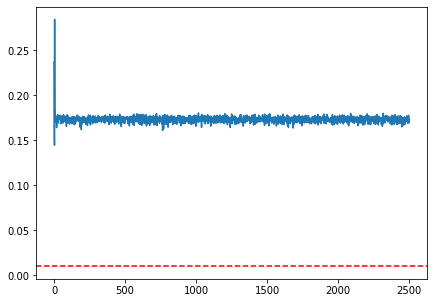

In [10]:
wt1, wt2 = nn_training(X_train, y_train, .1, threshold=.01, epoch_count=50)
nn_testing(X_test, y_test, wt1, wt2)

```The results of changing the activation funtion to Tanh() shows that he model overfitts and does not do well on the validation set. Even though it has a 91% accuracy for training, the testing accuracy is 26.67% and looking at the graph, the mean epoch error does not reach the threshold, instead it oscillates randomly around 0.17```

#  EXPERIMENT 3: Different Architectures  again using the Sigmoid Activation Function, learning rate = 0.1 & threshold = .01

```Reinstantiate the functions and chave the architectures to determine the results```

In [11]:
'''Activation Function for this network'''

def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

'''Append the entire matrix with a column of ones for the bias node'''

def append(X):
    height = X.shape[0] 
    bias_column = np.ones((height,1))
    X_appended = np.hstack((X,bias_column))
    return X_appended

'''This is the dot product between a weight matrix and the appended X matrix (one row at a time), this returns
an unactivated hidden layer of length 7, as specified by the dimensions of the problem'''

def h_raw(X,i,weight1=None): 
    if weight1 is None:
        weight1 = w_input(X)
    X_appended_row = append(X)[i]
    hraw = np.dot(X_appended_row, weight1)
    return hraw, weight1

'''This function now activates the hidden layer by applying the sigmoid activation function and returns the 
weight that was used to get from the input layer to the hidden layer'''

def h_activated(X,i,weight1=None):
    hidden_layer_raw, weight1 = h_raw(X,i,weight1)
    hactivated = sigmoid(hidden_layer_raw)
    return hactivated, weight1

'''Initializes a Weight Matrix for the hidden to output layer using the length of the activated hidden layer,
this also appends a random weight at the bottom of the matrix for the bias from hidden to output layer'''

def w_output(X, i, y_train, weight1=None):
    hactivated, _ = h_activated(X,i,weight1=weight1)
    rows = len(hactivated)
    W = np.random.sample((rows, 3)) - 0.5
    random_weight = np.random.sample([1]) - 0.5
    weight_vector = np.repeat(random_weight,3)
    W_output = np.insert(W, rows, weight_vector, axis=0)
    return W_output

'''This is the dot product between an appended activated hidden layer and W_output, this gives us the first
output layer values'''

def o_raw(X,i, weight1=None, weight2=None):
    hactivated, weight1 = h_activated(X, i , weight1)
    h_activated_with_bias = np.append(hactivated,[1]) 
    if weight2 is None:
        weight2 = w_output(X,i,weight1)
    oraw = np.dot(h_activated_with_bias, weight2)
    return oraw, weight2

'''This function now activates the output layer by applying the sigmoid activation function and returns the 
weight that was used to get from the hidden layer to the output layer'''

def o_activated(X,i, weight1=None, weight2=None):
    oraw, weight2 = o_raw(X,i, weight1=weight1, weight2=weight2)
    oactivated = sigmoid(oraw)
    return oactivated, weight2

'''This Error function determines the error of the output for the i-th row of the Matrix and the i-th target layer
and outputs a single value that will be used in the backpropogation steps'''

def error(X,y,i,weight1=None, weight2=None):
    oactivated, _ = o_activated(X, i, weight1=weight1, weight2=weight2)
    error = .5*((y[i] - oactivated)**2).sum()
    return error

'''The Feedforward Steps all conglomerated into one function from X matrix row to output activated. This catch-all
function will return the outputlayer actived for the i-th row, the weight matricies used form both the input layer
to hidden layer and from the hidden layer to the input layer and the associated erro'''

def feedforward(X, y, i, weight1=None, weight2=None):
    hactivated, weight1 = h_activated(X,i, weight1)
    oactivated, weight2 = o_activated(X,i, weight1=weight1, weight2=weight2)
    err = error(X,y,i,weight1=weight1, weight2=weight2)
    return oactivated, hactivated, err, weight1, weight2

'''First Step in Backpropogation, this produces the Gradient Matrix from the Hidden Layer to the
Output Layer (8x3)'''

def grad_hidden_to_output(X,y,i, oactivated, hactivated): 
    E = (oactivated - y[i]) * oactivated * (1 - oactivated)
    h_activated_transpose = np.array([[i] for i in hactivated])
    grad_hidden_to_output = h_activated_transpose * E 
    bias_gradient = ((oactivated - y[i]) * oactivated * (1 - oactivated)).sum()
    bias_h2o =  np.array([bias_gradient])
    len_bias_row = grad_hidden_to_output.shape[1]
    BG_H_O = np.repeat(bias_h2o[0],len_bias_row)
    hidden_to_output_gradient_matrix = np.vstack([grad_hidden_to_output, BG_H_O])
    return hidden_to_output_gradient_matrix

'''Updated Weights from the Input to Hidden Layer with learning rate lr'''

def update_input_hidden_weights(X,y,i,lr, oactivated, hactivated, weight1=None, weight2=None):
    input_to_hidden_gradient_matrix = grad_input_to_hidden(X, y, i, oactivated, hactivated, weight2)
    updated_weights_input_hidden = weight1 - lr * input_to_hidden_gradient_matrix
    return updated_weights_input_hidden

'''Updated Weights for Hidden to Output Layer with lr'''

def update_hidden_output_weights(X,y,i,lr, oactivated, hactivated, weight2=None):
    hidden_to_output_gradient_matrix =  grad_hidden_to_output(X,y,i, oactivated, hactivated)
    updated_weights_hidden_output = weight2 - lr * hidden_to_output_gradient_matrix
    return updated_weights_hidden_output

'''Backpropogation Function'''

def backpropogation(X,y,i,lr,oactivated,hactivated,weight1=None, weight2=None):
    updated_weight1 = update_input_hidden_weights(X,y,i,lr, oactivated, hactivated, weight1=weight1, weight2=weight2)
    updated_weight2 = update_hidden_output_weights(X,y,i,lr, oactivated, hactivated, weight2)
    oactivated1, hactivated1, err, updated_weight1, updated_weight2 = feedforward(X, y, i, weight1=updated_weight1, weight2=updated_weight2)
    return err, oactivated1, updated_weight1, updated_weight2

'''Transforms the Rows of all oactivated1 to one hot encoding to compare with y_trian'''

def output_encoder(Matrix):
    for row in Matrix:
        row[row.argmax(0)] = 1
        row[row < 1] = 0
    return Matrix

'''Creates a visualization of the Errors'''

def error_plotter(Matrix,threshold): 
    result = np.array(list(map(sum, Matrix))) / len(Matrix[0])
    index = np.array(list(range(len(result))))
    Ezz = np.vstack((index+1, result)).T
    x = Ezz[:,0]
    y = Ezz[:,1]
    plt.figure(figsize=(7,5))
    plt.plot(x,y)
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.show

'''This function returns the number of EPOCHS needed to reach convergence to the error threshold'''
    
def epochs_for_convergence(avg_error, threshold, X):
    for i in range(len(avg_error)):
        if avg_error[i] < threshold:
            count = i / len(X)
            return math.ceil(count)
        
def epochs_for_mean_convergence(normalized_error, threshold):
    for i in range(len(normalized_error)):
        if normalized_error[i] < threshold:
            count = i
            return math.ceil(count)

# [7,9,3]

In [12]:
'''Initializes a Weight Matrix from the input layer to the hidden layer using the length of a single row 
for argument Matrix X'''

def w_input(X):
    X_appended = append(X)
    rows = len(X[0])+2 
    cols = len(X[0])
    W = np.random.sample((cols, rows)) - 0.5
    random_bias_weight = np.random.sample()
    bias_row = np.repeat(random_bias_weight, rows)
    W_input = np.insert(W, cols, bias_row, axis=0)
    return W_input

'''The Gradient Matrix from the Input Layer to the Hidden Layer (8x7)'''

def grad_input_to_hidden(X, y, i, oactivated, hactivated, W_output):
    input_layer = X[i]
    target_layer = y[i]
    W_output_wo_bias = W_output[:-1,:] 
    E = (oactivated - target_layer) * oactivated * (1 - oactivated) 
    grad_input_to_hidden = np.zeros((7,9))
    for j in range(len(hactivated)):
        pt1 = []  
        pt2 = []
        pt1.append( np.dot(E, W_output_wo_bias[j]) ) 
        pt2.append( hactivated[j] * (1 - hactivated[j])) 
        grad_input_to_hidden[:,j] = np.array(pt1) * np.array(pt2) * input_layer
    pt3 = np.dot(E, W_output_wo_bias.T)
    pt4 = hactivated *(1-hactivated)
    bias_gradient_il = np.dot(pt3,pt4)
    len_bias_row = hactivated.shape[0]
    BG_I_H = np.repeat(bias_gradient_il, len_bias_row)
    input_to_hidden_gradient_matrix = np.vstack((grad_input_to_hidden, BG_I_H))
    return input_to_hidden_gradient_matrix


After 2500 epochs, the accuracy is 100.0%
Final Error = 0.00275
The Number of Epochs for the Mean Epoch Error to dip below the threshold is 1222
Accuracy using updated weights from training set with is 96.67%


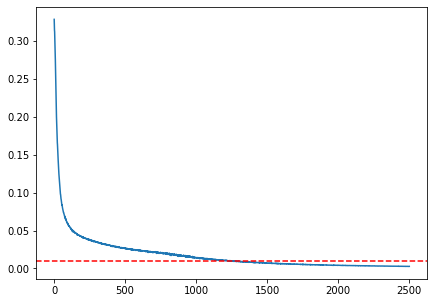

In [13]:
wt1, wt2 = nn_training(X_train, y_train, .1, threshold=.01, epoch_count=2500)
nn_testing(X_test, y_test, wt1, wt2)

```This larger hidden layer works better on all metrics than our original [7,7,3]```

# [7,3,3] Archiceture

In [14]:
'''Initializes a Weight Matrix from the input layer to the hidden layer using the length of a single row 
for argument Matrix X'''

def w_input(X):
    X_appended = append(X)
    rows = len(X[0])-4 
    cols = len(X[0])
    W = np.random.sample((cols, rows)) - 0.5
    random_bias_weight = np.random.sample()
    bias_row = np.repeat(random_bias_weight, rows)
    W_input = np.insert(W, cols, bias_row, axis=0)
    return W_input

'''The Gradient Matrix from the Input Layer to the Hidden Layer (8x7)'''

def grad_input_to_hidden(X, y, i, oactivated, hactivated, W_output):
    input_layer = X[i]
    target_layer = y[i]
    W_output_wo_bias = W_output[:-1,:] 
    E = (oactivated - target_layer) * oactivated * (1 - oactivated) 
    grad_input_to_hidden = np.zeros((7,3))
    for j in range(len(hactivated)):
        pt1 = []  
        pt2 = []
        pt1.append( np.dot(E, W_output_wo_bias[j]) ) 
        pt2.append( hactivated[j] * (1 - hactivated[j])) 
        grad_input_to_hidden[:,j] = np.array(pt1) * np.array(pt2) * input_layer
    pt3 = np.dot(E, W_output_wo_bias.T)
    pt4 = hactivated *(1-hactivated)
    bias_gradient_il = np.dot(pt3,pt4)
    len_bias_row = hactivated.shape[0]
    BG_I_H = np.repeat(bias_gradient_il, len_bias_row)
    input_to_hidden_gradient_matrix = np.vstack((grad_input_to_hidden, BG_I_H))
    return input_to_hidden_gradient_matrix

After 2500 epochs, the accuracy is 99.33%
Final Error = 0.01068
The Number of Epochs for the Mean Epoch Error to dip below the threshold is None
Accuracy using updated weights from training set with is 96.67%


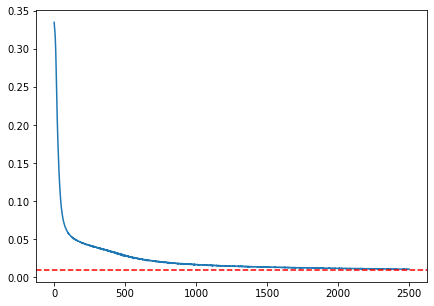

In [15]:
wt1, wt2 = nn_training(X_train, y_train, .1, threshold=.01, epoch_count=2500)
nn_testing(X_test, y_test, wt1, wt2)

```The training and testing accuracies is great but the Epoch mean error never dips below the error threshold```

# [7,5,3]

In [16]:
'''Initializes a Weight Matrix from the input layer to the hidden layer using the length of a single row 
for argument Matrix X'''

def w_input(X):
    X_appended = append(X)
    rows = len(X[0])-2
    cols = len(X[0])
    W = np.random.sample((cols, rows)) - 0.5
    random_bias_weight = np.random.sample()
    bias_row = np.repeat(random_bias_weight, rows)
    W_input = np.insert(W, cols, bias_row, axis=0)
    return W_input

'''The Gradient Matrix from the Input Layer to the Hidden Layer (8x7)'''

def grad_input_to_hidden(X, y, i, oactivated, hactivated, W_output):
    input_layer = X[i]
    target_layer = y[i]
    W_output_wo_bias = W_output[:-1,:] 
    E = (oactivated - target_layer) * oactivated * (1 - oactivated) 
    grad_input_to_hidden = np.zeros((7,5))
    for j in range(len(hactivated)):
        pt1 = []  
        pt2 = []
        pt1.append( np.dot(E, W_output_wo_bias[j]) ) 
        pt2.append( hactivated[j] * (1 - hactivated[j])) 
        grad_input_to_hidden[:,j] = np.array(pt1) * np.array(pt2) * input_layer
    pt3 = np.dot(E, W_output_wo_bias.T)
    pt4 = hactivated *(1-hactivated)
    bias_gradient_il = np.dot(pt3,pt4)
    len_bias_row = hactivated.shape[0]
    BG_I_H = np.repeat(bias_gradient_il, len_bias_row)
    input_to_hidden_gradient_matrix = np.vstack((grad_input_to_hidden, BG_I_H))
    return input_to_hidden_gradient_matrix

After 2500 epochs, the accuracy is 99.33%
Final Error = 0.00894
The Number of Epochs for the Mean Epoch Error to dip below the threshold is 2172
Accuracy using updated weights from training set with is 95.0%


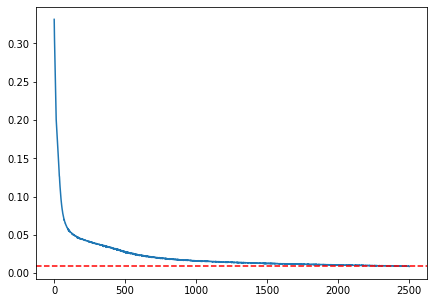

In [17]:
wt1, wt2 = nn_training(X_train, y_train, .1, threshold=.01, epoch_count=2500)
nn_testing(X_test, y_test, wt1, wt2)

```This Architecture is very good. This is about as good as [7,9,3]```